Wnioski z "The spelled out-intro .. building micrograd"

Można robić __rmul__: to zapasowe __mul__, używane jak pierwsze nie zadziała
Jest coś takiego jak grad i data. Na początku losujemy parametry, potem na podstawie gradientu jakoś schodzimy w dół
Trzeba za każdym razem zerować gradienty

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
# Z tego co rozumiem to po prostu od rau daje rysunek
%matplotlib inline

In [14]:
class Value:
    def __init__(self, data, _children=(), _op ='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    def __repr__(self):
        return f"Value:{self.data}"
    
    def __add__(self, other):

        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    def __mul__(self, other):

        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    def __rmul__(self, other):
        return other * self
    def tanh(self):
        n = self.data
        t =  (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        n = self.data
        t = math.exp(n)
        out = Value(t, (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)
    def __rsub__(self, other): # self - other
        return other + (-self)

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [15]:
from graphviz import Digraph

# Z grubsza robi ala DFSa do tyłu
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

# Rysuje
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot




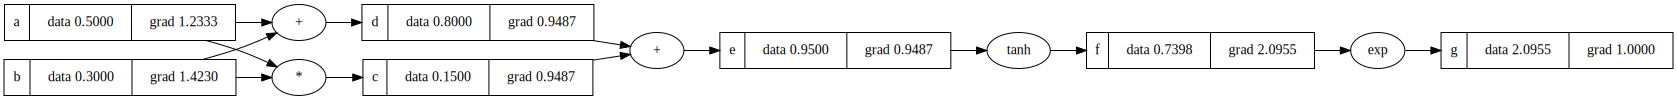

In [16]:
# Przykład użycia
a = Value(0.5, label='a')
b = Value(0.3, label='b')
c = b * a; c.label = 'c'
d = b + a; d.label = 'd'
e = c + d; e.label = 'e'
f = e.tanh(); f.label='f'
g = f.exp(); g.label = 'g'
g.backward()
draw_dot(g)

In [17]:
import torch


#.double() zwiększa z 32 do 64 precyzję
x1 = torch.Tensor([2.0]).double()   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ; w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad  = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print('----')
print(x1.data.item())
print(x2.data.item())
print(w1.data.item())
print(w2.data.item())
print('--grad--')
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

0.7071050214706146
----
2.0
0.0
-3.0
1.0
--grad--
-1.500007465833125
0.5000024886110417
1.0000049772220834
0.0


In [23]:
import random
class Neuron:
    def __init__(self, nin):
        #weights
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        # Jakby tworzymy na podstawie neuronów w inpucie (nin)
        self.neurons =[Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        # Jakby tworzymy na podstawie neuronów w inpucie (nin)
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [44]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4 , 4, 1])
n(x)

Value:0.9071863020760329

In [45]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value:0.9071863020760329,
 Value:0.9463005806668785,
 Value:0.9132144934358759,
 Value:0.8535807257586783]

In [35]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value:4.831773044478697e-30

In [ ]:
loss.backward()
draw_dot(loss)

41

In [46]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    print(loss)

    for p in n.parameters():
        p.grad = 0.0
        
    loss.backward()

    for p in n.parameters():
        p.data -= p.grad * 0.05
    print(f"result: {ypred}")

Value:7.478528634589
result: [Value:0.9071863020760329, Value:0.9463005806668785, Value:0.9132144934358759, Value:0.8535807257586783]
Value:7.150401717928446
result: [Value:0.8418999636200881, Value:0.9104109648769537, Value:0.852871193918345, Value:0.7935917141909494]
Value:6.304427904520545
result: [Value:0.6605656287625316, Value:0.8012580135308719, Value:0.6819501332376791, Value:0.6598154469471897]
Value:4.307179084295315
result: [Value:0.09461994691978566, Value:0.32307581129451196, Value:0.1263449618357325, Value:0.31568759451956796]
Value:3.347652746643947
result: [Value:-0.34360310639981284, Value:-0.3256732693324849, Value:-0.3104653905167755, Value:0.21756219304739793]
Value:2.9469529073459237
result: [Value:0.2461396729070319, Value:-0.02242869873068412, Value:0.16164308799624877, Value:0.7287303894160586]
Value:2.3613117092642377
result: [Value:-0.3484999639117789, Value:-0.7092682823886896, Value:-0.5613636603635208, Value:0.484313286462355]
Value:2.4024313926859837
resul